In [230]:
import cv2
import numpy as np
import pydicom as dicom
from matplotlib import pyplot as plt
import math
import imutils

In [231]:
cv2._version_

AttributeError: module 'cv2' has no attribute '_version_'

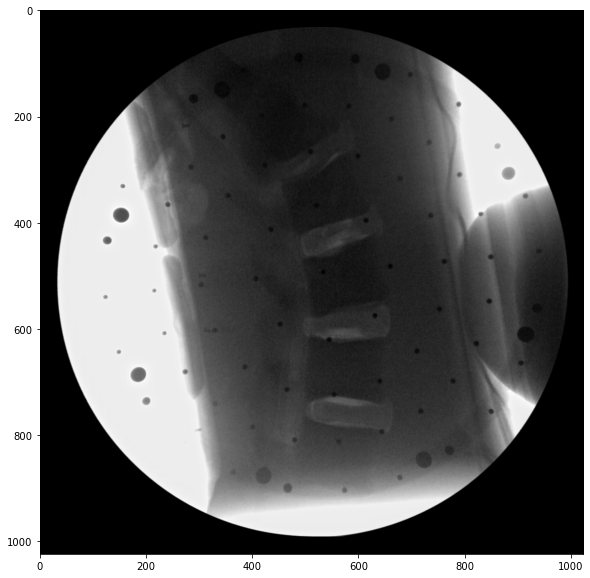

In [86]:
#reading image
I1 = dicom.dcmread('IM3').pixel_array
plt.imshow(I1,'gray')

In [87]:
!ls

Gaussian blur_1.png               adjustedimage1.dcm
IM15UD.dcm                        adjustedimage1.png
IM15UD.jpg                        dcm.png
IM19OP.png                        fig1.png
IM19UD.dcm                        imadjust_try.ipynb
IM21UD.dcm                        img15_blur.dcm
IM25OP.png                        img1_1.DCM
IM25UD.dcm                        img2_1.DCM
IM3                               llf.py
IM31UD.dcm                        op1.png
IM39UD.dcm                        out.dcm
IM_ADJUST_ALTERNATIVE_MANSI.ipynb task1_read.m
ImAdjust_alt.py                   task1_w1.py
Untitled.ipynb                    untitled0.py
__pycache__                       untitled1.py
adjustedimage.png


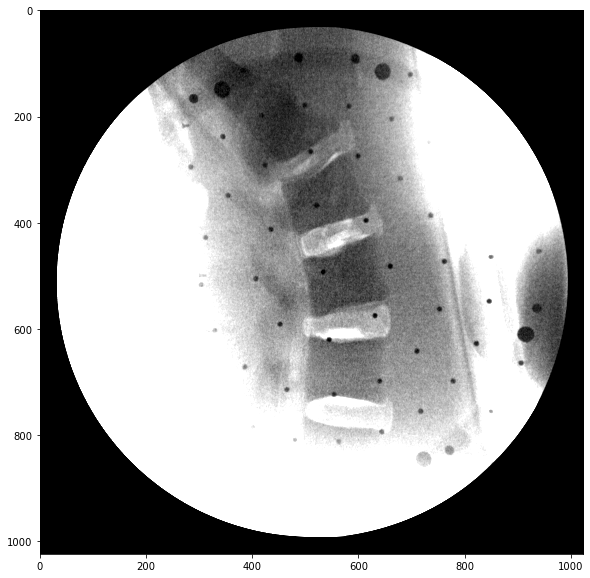

In [88]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(I1,cmap='gray',vmin=1700,vmax=16300)
plt.show()

In [39]:
I1.min(),I1.max()

(8, 60700)

In [40]:
I1.dtype

dtype('uint16')

In [74]:
size = np.shape(I1)

In [89]:
import bisect

def imadjust(src, tol=1, vin=[0,65535], vout=(0,65535)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'

    tol = max(0, min(100, tol))   
    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(65536)),range=(0,65535))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(0, 65535): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_right(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    vs = src-vin[0]
    vs[src<vin[0]]=0
    vd = vs*scale+0.5 + vout[0]
    vd[vd>vout[1]] = vout[1]
    dst = vd

    return dst

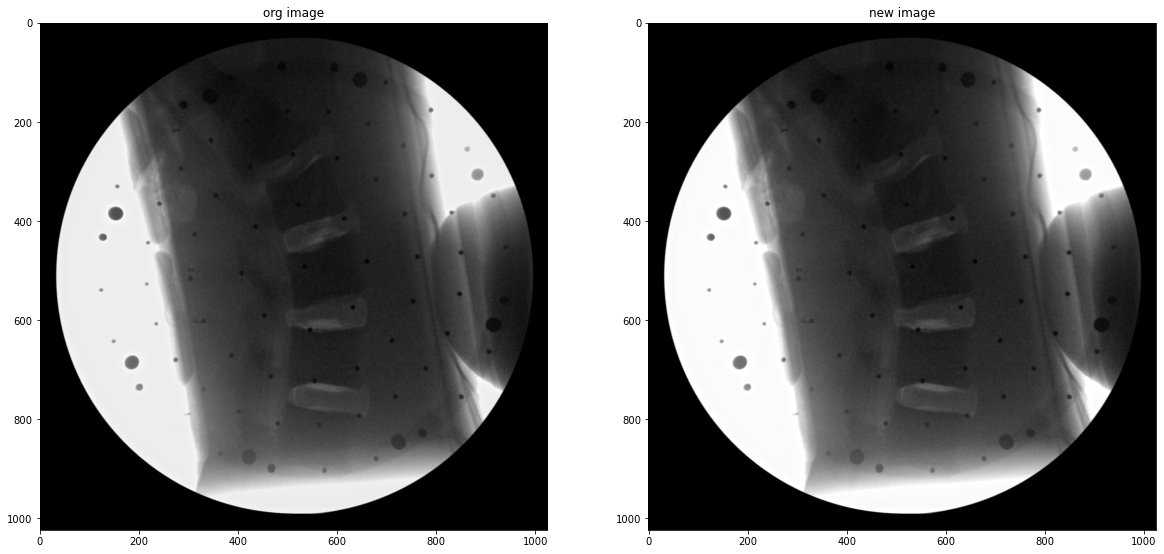

In [90]:
out=imadjust(I1)

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('org image')
ax1.imshow(I1,cmap = 'gray')
ax2.set_title('new image')
ax2.imshow(out,cmap = 'gray')
plt.show()

In [91]:
out.min(),out.max()

(0.5, 65535.0)

(1024, 1024)

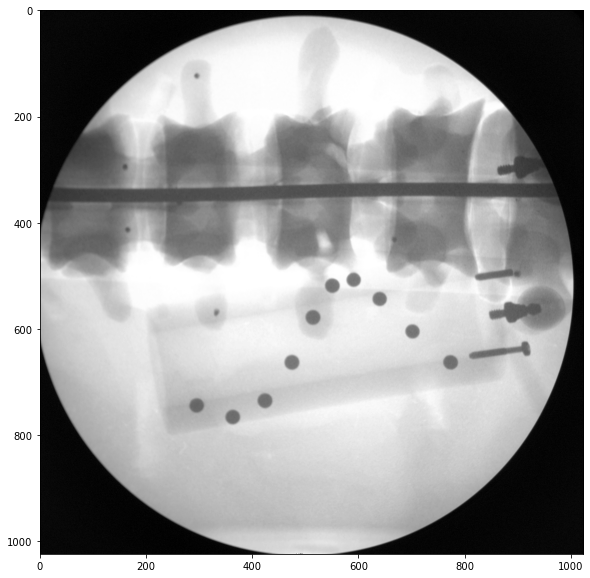

In [68]:
adjusted = dicom.dcmread('adjustedimage1.dcm').pixel_array
plt.imshow(adjusted,'gray')
np.shape(adjusted)

In [92]:
temp = out-adjusted
temp.min(), temp.max()

(-65534.5, 53338.0)

In [47]:
adjusted.dtype

dtype('uint16')

# LOCAL CONTRAST


In [48]:
import math
import scipy
def llf(I,sigma,fact,N):
    (height,width)=I.shape
    n_levels=math.ceil(math.log(min(height,width))-math.log(2))+2
    discretisation=np.linspace(0,1,N)
    discretisation_step=discretisation[1]
    input_gaussian_pyr=gaussian_pyramid(I,n_levels,None)
    output_laplace_pyr=laplacian_pyramid(np.zeros((height,width)),n_levels,None)
    output_laplace_pyr[n_levels-1]=input_gaussian_pyr[n_levels-1]
    for ref in discretisation:
        I_remap=fact*(I-ref)*np.exp(-(I-ref)*(I-ref)/(2*sigma*sigma))
        temp_laplace=laplacian_pyramid(I_remap,n_levels,None)
        for level in range(0,n_levels-1):        
            output_laplace_pyr[level]=output_laplace_pyr[level]+((np.abs(input_gaussian_pyr[level]-ref) < discretisation_step))*temp_laplace[level]*(1-np.abs(input_gaussian_pyr[level]-ref)/discretisation_step)

    F=reconstruct_laplacian_pyramid(output_laplace_pyr,None)
    return F
def xllf(I1,I2,sigma,fact,N):
    (height,width)=I1.shape
    n_levels=math.ceil(math.log(min(height,width))-math.log(2))+2
    discretisation=np.linspace(0,1,N)
    discretisation_step=discretisation[1]
    input_gaussian_pyr=gaussian_pyramid(I2,n_levels,None)
    output_laplace_pyr=laplacian_pyramid(np.zeros((height,width)),n_levels,None)
    output_laplace_pyr[n_levels-1]=input_gaussian_pyr[n_levels-1]
    for ref in discretisation:
        I_remap=I1+fact*(I1-ref)*np.exp(-(I2-ref)*(I2-ref)/(2*sigma*sigma))
        temp_laplace=laplacian_pyramid(I_remap,n_levels,None)
        for level in range(0,n_levels-1):        
            output_laplace_pyr[level]=output_laplace_pyr[level]+((np.abs(input_gaussian_pyr[level]-ref) < discretisation_step))*temp_laplace[level]*(1-np.abs(input_gaussian_pyr[level]-ref)/discretisation_step)

    F=reconstruct_laplacian_pyramid(output_laplace_pyr,None)
    return F
def gaussian_pyramid(I,nlev,subwindow):
    (r,c)=I.shape
    if subwindow is None:
        subwindow=[0,r,0,c]
    if nlev is None:
        nlev=numlevels([r,c])    
    pyr=np.empty((nlev),dtype=object)
    pyr[0]=I
    fil=pyramid_filter()
    for i in range(1,nlev):
        I,sub=downsample(I,fil)
        pyr[i]=I
    return pyr
def numlevels(im_sz):
    min_d=min(im_sz)
    nlev=1
    while min_d>1:
        nlev=nlev+1
        min_d=(min_d+1)//2
    return nlev
def child_windows(parent,N=1):
    if N is None:
        N=1
    child =np.array(parent)
    for k in range(N):
        child = (child)/2
        child[0]=math.ceil(child[0])
        child[2]=math.ceil(child[2])
        child[1]=math.floor(child[1])
        child[3]=math.floor(child[3])

    return child
def downsample(I,filter):    
    r,c=I.shape    
    subwindow=[0, r ,0 ,c]
    subwindow_child=child_windows(subwindow)    
    R=cv.filter2D(I,-1,filter,borderType=cv.BORDER_CONSTANT)
    Z=cv.filter2D(np.float32(np.ones(I.shape)),-1,filter,borderType=cv.BORDER_CONSTANT)
    R=R/Z
    reven=(subwindow[0]%2==0)*1
    ceven=(subwindow[2]%2==0)*1
    row=np.arange(0+reven,r,2)
    col=np.arange(0+ceven,c,2)
    R=R[row][:]
    R=R[:,col]
    
    return (R,subwindow_child)
def pyramid_filter():
    f=np.asmatrix(np.array([0.05, 0.25, 0.4, 0.25, 0.05])).T
    f=f.dot(f.T)
    return f
def laplacian_pyramid(I,nlev,subwindow):
    (r,c)=I.shape
    if subwindow is None:
        subwindow=np.array([0,r,0,c])*1.0
    if nlev is None:
        nlev=numlevels([r,c])-1
    pyr=np.empty((nlev),dtype=object)
    fil=pyramid_filter()
    J=I
    for l in range(0,nlev-1):  
        
        (I,subwindow_child)=downsample(I,fil)        
        up=upsample(I,fil,subwindow)
        pyr[l]=J-up
        J=I
        subwindow=subwindow_child
    pyr[nlev-1]=J
    return pyr
def upsample(I,fil,subwindow):
    r=subwindow[1]-subwindow[0]
    c=subwindow[3]-subwindow[2]
    #k=size(I,3)
    reven=(subwindow[0]%2==0)*1
    ceven=(subwindow[2]%2==0)*1
    R=0
    R=np.zeros((int(r),int(c)))
    row=np.arange(0+reven,r,2)
    col=np.arange(0+ceven,c,2)     
    col_c,row_r,=np.meshgrid(col,row) 
    
    R[row_r.astype(int),col_c.astype(int)]=I
    R=cv.filter2D(R,-1,fil,anchor=(-1,-1),borderType=cv.BORDER_CONSTANT)
    Z=np.zeros((int(r),int(c)))        
    Z[row_r.astype(int),col_c.astype(int)]=np.ones(I.shape)
    Z=cv.filter2D(Z,-1,fil,borderType=cv.BORDER_CONSTANT)
    R=R/Z
    
    return R
def reconstruct_laplacian_pyramid(pyr,subwindow):
    (r,c)=pyr[0].shape
    nlev=pyr.size
    
    subwindow_all=np.zeros((nlev,4))
    if subwindow is None:
        subwindow_all[0,:]=[0,r,0,c]
        
    else:
        subwindow_all[1,:]=subwindow
    for lev in range(1,nlev):
        subwindow_all[lev,:]=child_windows(subwindow_all[lev-1,:])
    
    R=pyr[nlev-1]    
    fil=pyramid_filter()
    for lev in range(nlev-2,-1,-1):        
        R=pyr[lev]+upsample(R,fil,subwindow_all[lev,:])
    return R
def repeat(I):
    (r,c)=I.shape
    m=np.zeros((r,c,3))
    m[:,:,0]=I
    m[:,:,1]=I
    m[:,:,2]=I
    return m

In [52]:
amount = 0.25 #default value
alpha = 0.01*amount
#edge threshold sigma
edge = 0.3 #default value
beta = 1

#values as in the code, just testing
sigma = 0.1
fact = -0.75
N=2

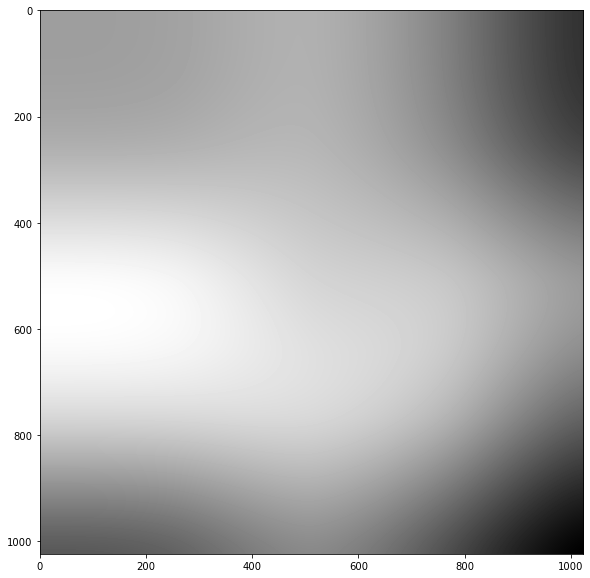

In [53]:
plt.imshow(lc_img,'gray')

# SRETCH LIM FUNCTION

In [ ]:
def stretchlim(img):
    #defining tolerance 
    tol_low = 0.01
    tol_high = 0.99
    
    # Determine size of image in pixels
    sz = np.shape(img)
    num_of_px = sz[0]*sz[1]
    
    # Determine one percent of total pixels (for use in image adjust code)
    one_perc = math.floor(num_of_px*0.01)
    lims = np.zeros((1,2))
    # Compute lower/upper 1% threshold for each channel
    for i in range(0,1):
        hist,bins = np.histogram(img[:,:,i].ravel(),255,[0,255])
        val = 0; j = 0;
        while val < one_perc:
            val = val+hist[j]
            j = j +1
        lims[i,0] = j
        val = 0; j = 0;
        while val < one_perc:
            val = val+hist[254-j]
            j = j + 1
        lims[i,1] = 254-j
    return lims

# Blob Detection openCV

In [251]:
#uint16 to unit8 conversion
im1 = cv.convertScaleAbs(out, alpha=(255.0/65535.0))


70


/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_8010/426355360.py:27: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  params.blobColor = 0.4


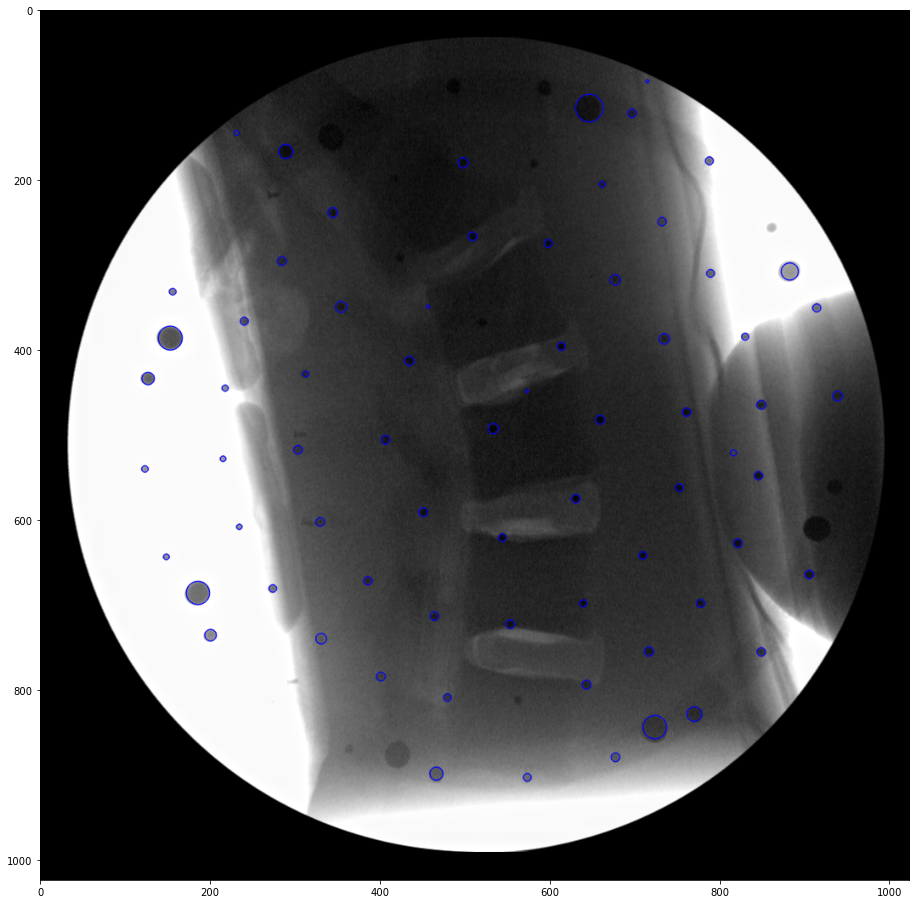

In [154]:
# Setup SimpleBlobDetector parameters.
params = cv.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 1
params.maxThreshold = 200


# Filter by Area.
params.filterByArea = True
params.minArea = 13

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.3

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.8

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.03

# using intensity value as parameter (0.5 or 0.7) 
params.filterByColor = True
params.blobColor = 0.4


# Create a detector with the parameters
# OLD: detector = cv2.SimpleBlobDetector(params)
detector = cv.SimpleBlobDetector_create(params)

#detect blobs
keypoints = detector.detect(im1)

#draw blobs
im_with_keypoints = cv.drawKeypoints(im1, keypoints, np.zeros((1, 1)), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
number_of_blobs = len(keypoints)
text = "Number of Circular Blobs: " + str(len(keypoints))

#M = cv.moments(thresh)

# calculate x,y coordinate of center
#cX = int(M["m10"] / M["m00"])
#cY = int(M["m01"] / M["m00"])

# put text and highlight the center
#cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)


#circles = np.uint16(np.around(im_with_keypoints))
#for i in circles[0,:]:
    # draw the outer circle
 #   cv.circle(im_with_keypoints,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
  #  cv.circle(im_with_keypoints,(i[0],i[1]),2,(0,0,255),3)

print(number_of_blobs)
plt.figure(figsize = (16,16))
plt.imshow(im_with_keypoints,'gray')




/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_8010/2475086318.py:27: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  params.blobColor = 0.4


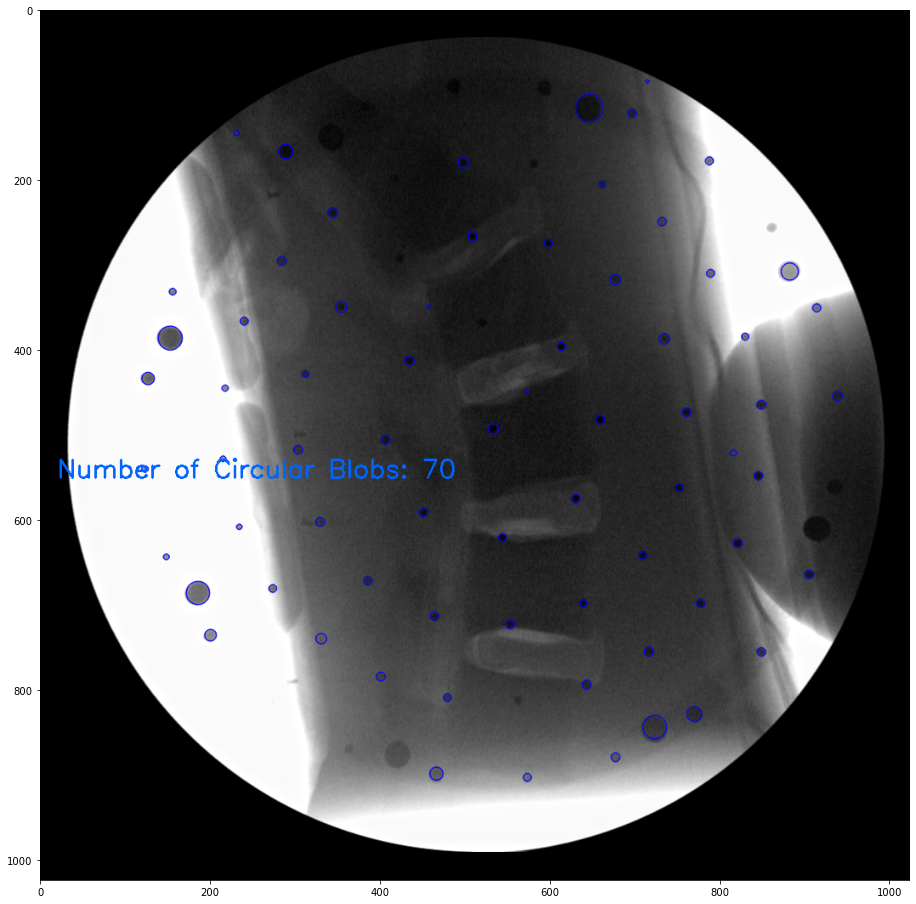

In [274]:
#GEEKSFORGEEKS METHOD:
params = cv.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 1
params.maxThreshold = 200

# Set Area filtering parameters
params.filterByArea = True
params.minArea = 13
 
# Set Circularity filtering parameters
params.filterByCircularity = True
params.minCircularity = 0.3
 
# Set Convexity filtering parameters
params.filterByConvexity = True
params.minConvexity = 0.8
     
# Set inertia filtering parameters
params.filterByInertia = True
params.minInertiaRatio = 0.03


# using intensity value as parameter (0.5 or 0.7) 
params.filterByColor = True
params.blobColor = 0.4

# Create a detector with the parameters
detector = cv.SimpleBlobDetector_create(params)
     
# Detect blobs
keypoints = detector.detect(im1)
 
# Draw blobs on our image as red circles
blank = np.zeros((1, 1))
blobs = cv.drawKeypoints(im1, keypoints, blank, (0, 0, 255),
                          cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
number_of_blobs = len(keypoints)
text = "Number of Circular Blobs: " + str(len(keypoints))
cv.putText(blobs, text, (20, 550), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2)

plt.figure(figsize = (16,16))
plt.imshow(blobs)


# Alternate code


Connectivity   Connectivity of the MSER regions (default is 8)

       ImageSize      Size of I.

       NumObjects     Number of MSER regions in I.

       PixelIdxList   1-by-NumObjects cell array where the kth element
                      in the cell array is a vector containing the linear
                      indices of the pixels in the kth MSER region.

   regions = detectMSERFeatures(I,Name,Value) specifies additional
   name-value pair arguments described below:
   
       'ThresholdDelta'   Scalar value, 0 < ThresholdDelta <= 100, expressed
                          as a percentage of the input data type range. Typical values range from 0.8 to 4.
                          Default: 2

       'RegionAreaRange'  Two-element vector, [minArea maxArea], which specifies the size of the regions in pixels
                          Default: [30 14000]
                          
       'MaxAreaVariation' Positive scalar.  Typical values range from 0.1 to 1.0.
                          Default: 0.25      
                          
       'ROI'              A vector of the format [X Y WIDTH HEIGHT]
                          Default: [1 1 size(I,2) size(I,1)]
                          

# MASKING

In [125]:
im1.shape

(1024, 1024)

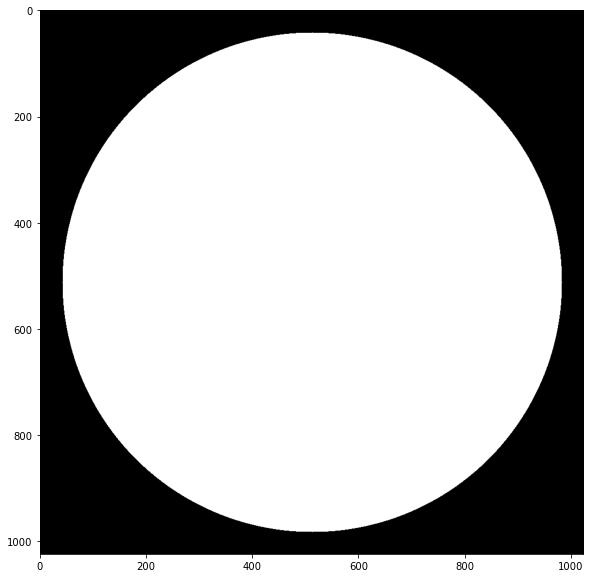

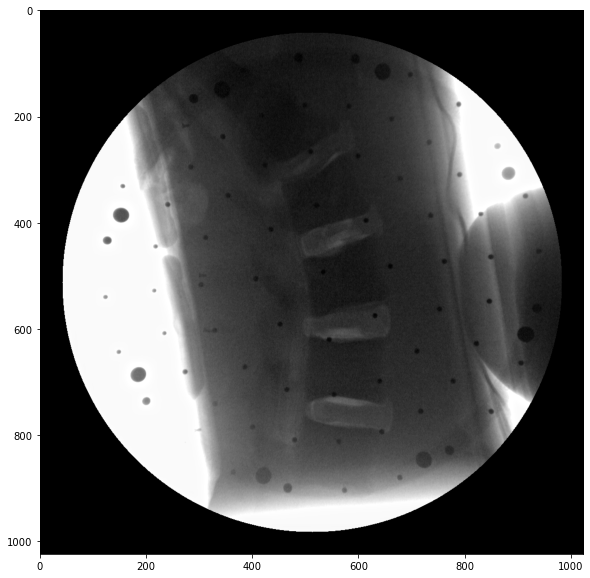

In [182]:
mask = np.zeros(im1.shape[:2], dtype="uint8")
cv.circle(mask, (512, 512), 470, 255, -1)
plt.imshow(mask,'gray')
plt.show()
# apply our mask -- notice how only the person in the image is
# cropped out
masked = cv.bitwise_and(im1, im1, mask=mask)
plt.imshow(masked,'gray')
plt.show()

# Canny Edge Detection in OpenCV

Observing difference between normal image and masked image

In [183]:
edges1 = cv.Canny(im1,90,150)
edges2 = cv.Canny(masked,90,150)

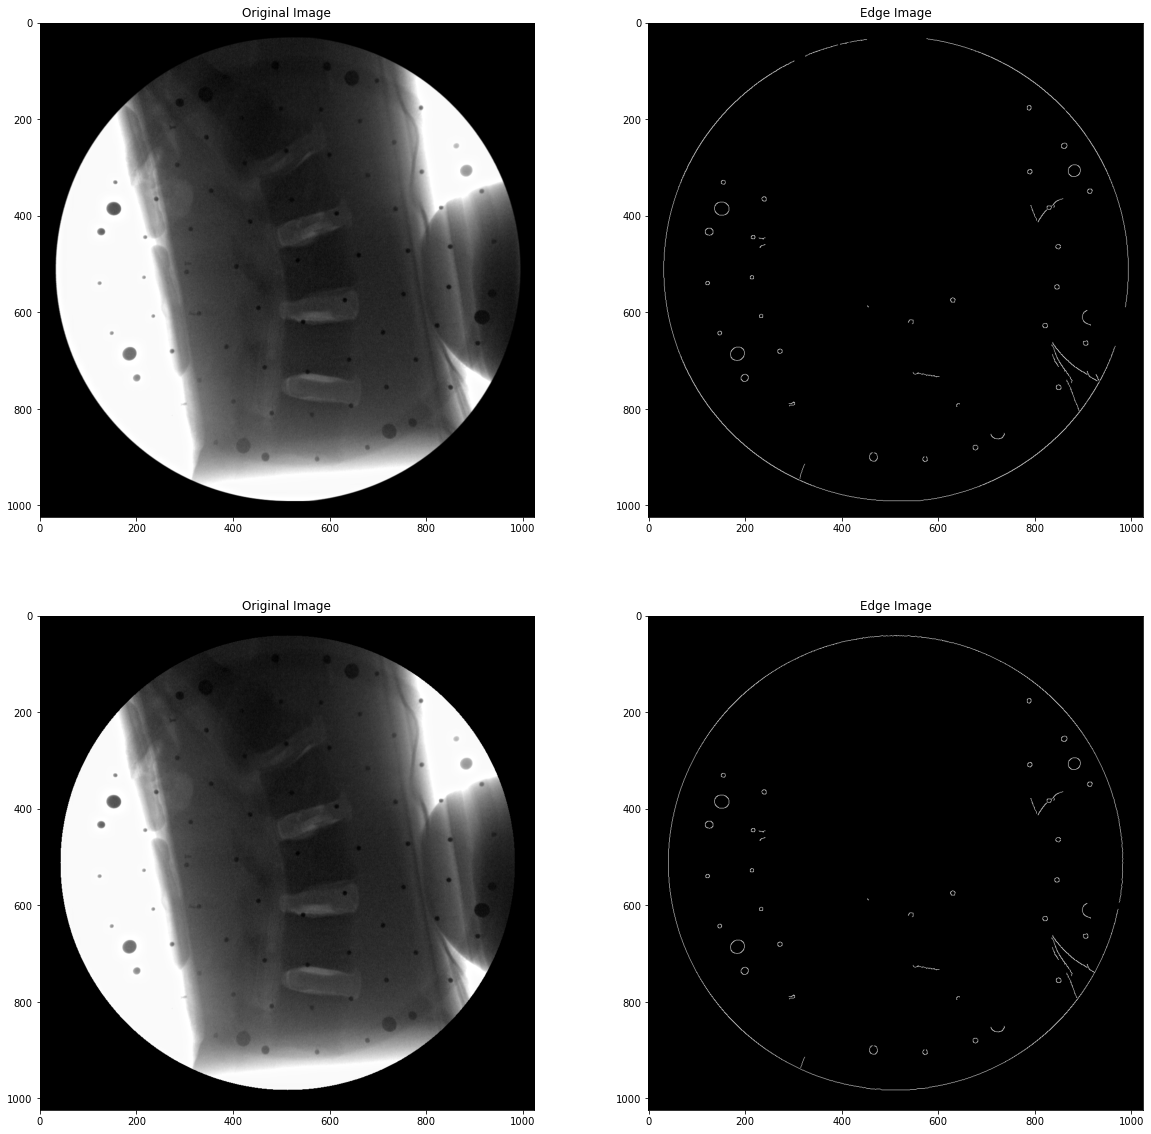

In [202]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(20,20))
ax1.set_title('Original Image')
ax1.imshow(im1,cmap = 'gray')
ax2.set_title('Edge Image')
ax2.imshow(edges1,cmap = 'gray')
ax3.set_title('Original Image')
ax3.imshow(masked,cmap = 'gray')
ax4.set_title('Edge Image')
ax4.imshow(edges2,cmap = 'gray')
plt.show()

# Masking - bounding box

In [208]:
thresh = cv.threshold(im1, 200, 255, cv.THRESH_BINARY)[1]
# find contours in thresholded image, then grab the largest
# one
#cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnts, contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv.contourArea)
# draw the contours of c
cv.drawContours(im1, [c], -1, (0, 0, 255), 2)


Exception: Contours tuple must have length 2 or 3, otherwise OpenCV changed their cv2.findContours return signature yet again. Refer to OpenCV's documentation in that case

In [210]:
ret,thresh = cv.threshold(im1,127,255,0)
im2,contours = cv.findContours(thresh, 1, 2)
for item in range(len(contours)):
    cnt = contours[item]
    if len(cnt)>20:
        print(len(cnt))
        M = cv.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        x,y,w,h = cv.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

203


error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/moments.cpp:602: error: (-210:Unsupported format or combination of formats)  in function 'moments'


In [227]:
ret,thresh = cv.threshold(im1,127,255,0)
im2,contours = cv.findContours(thresh, 1, 2)
contours = np.int8(contours)
cnt = contours[0]
print(cnt.dtype)
#Get the moments
mu = [None]*len(contours)
for i in range(len(contours)):
    mu[i] = cv.moments(contours[i])
M = cv.moments(cnt)
#print( M )

int8


error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/moments.cpp:602: error: (-210:Unsupported format or combination of formats)  in function 'moments'


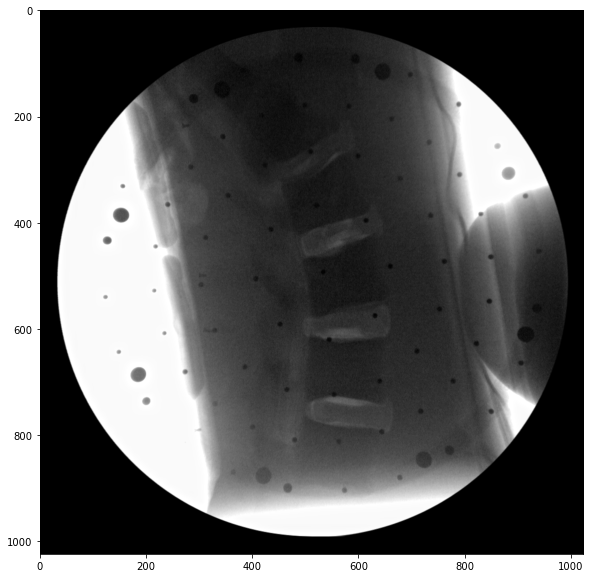

In [194]:
plt.imshow(im1,'gray')

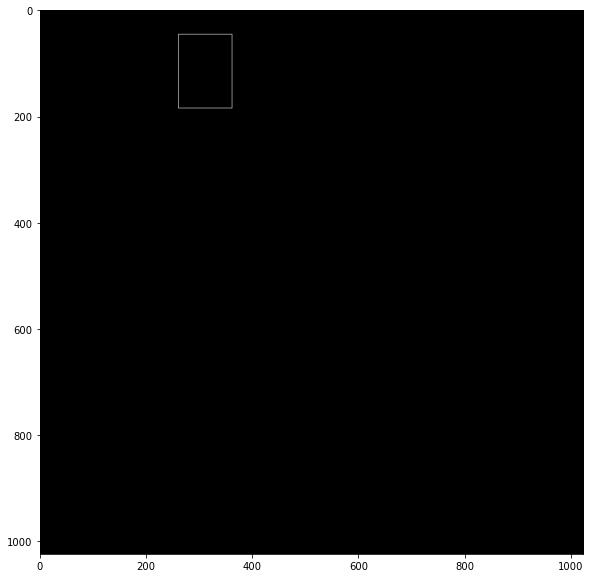

In [200]:
xmin = 260
xmax = 361
ymin = 45
ymax = 184
mask = im1.copy()
mask[:] = 0
num_channels = 1 if len(mask.shape) == 2 else mask.shape[2]
cv.rectangle(mask, (xmin, ymin), (xmax, ymax), color=(255,) * num_channels)
plt.imshow(mask,'gray')

In [273]:
mser = cv2.MSER_create(delta = 1,min_area = 50,max_area = 1000)
regions, _ = mser.detectRegions(im1)
print(regions)

(array([[492,  84],
       [491,  85],
       [490,  85],
       [491,  86],
       [491,  88],
       [491,  87],
       [490,  87],
       [489,  86],
       [488,  86],
       [488,  87],
       [489,  85],
       [492,  87],
       [490,  86],
       [492,  85],
       [487,  86],
       [490,  88],
       [491,  91],
       [491,  90],
       [491,  89],
       [492,  89],
       [493,  90],
       [493,  89],
       [490,  90],
       [490,  91],
       [491,  94],
       [490,  94],
       [490,  95],
       [490,  96],
       [491,  96],
       [492,  93],
       [492,  92],
       [492,  94],
       [490,  93],
       [489,  96],
       [491,  95],
       [492,  95],
       [488,  92],
       [488,  93],
       [488,  94],
       [487,  93],
       [489,  92],
       [486,  94],
       [486,  95],
       [486,  93],
       [487,  96],
       [487,  95],
       [487,  94],
       [488,  90],
       [487,  90],
       [489,  89],
       [488,  89],
       [488,  91],
       [487

In [236]:
im_with_keypoints = cv.drawKeypoints(im1, regions, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'drawKeypoints'
> Overload resolution failed:
>  - Can't parse 'keypoints'. Sequence item with index 0 has a wrong type
>  - Can't parse 'keypoints'. Sequence item with index 0 has a wrong type


156


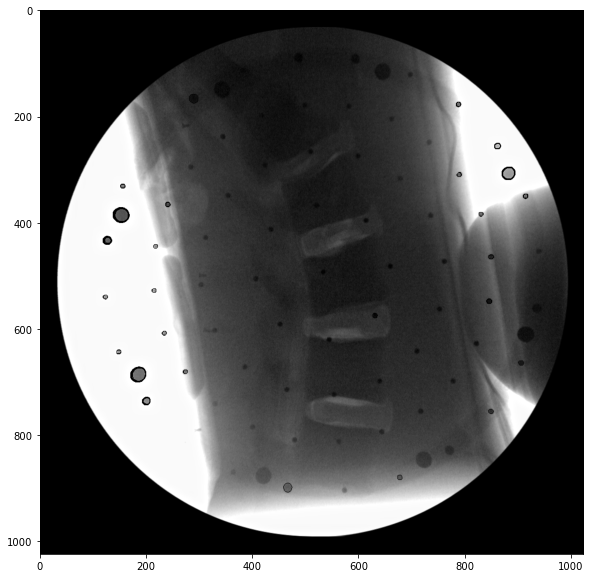

In [250]:
hulls = [cv.convexHull(p.reshape(-1, 1, 2)) for p in regions] # regions is a list of (numpy) arrays. each of those arrays is variableNX2 sized. you transform it into a NX1X2 (list?)
print(len(regions))
img_mser = cv.polylines(im1, hulls, 1, (0, 255, 0))
plt.imshow(img_mser,'gray')

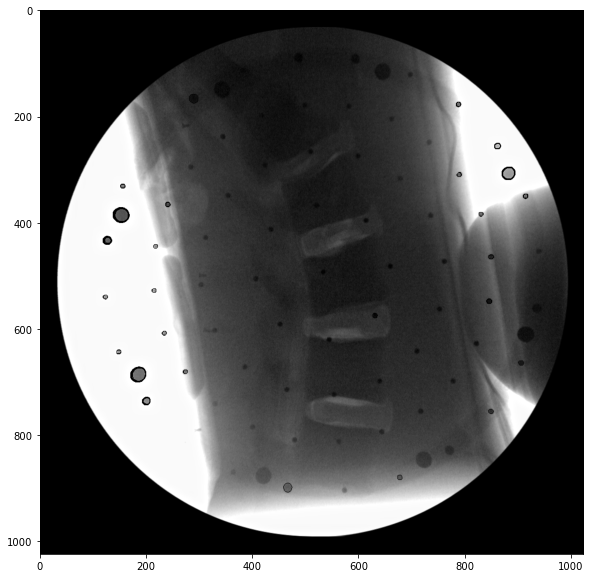

In [245]:
plt.imshow(im1,'gray')

In [258]:
import random as rng

In [270]:
hull_list = []
for i in range(len(regions)):
    hull = cv.convexHull(regions[i])
    hull_list.append(hull)


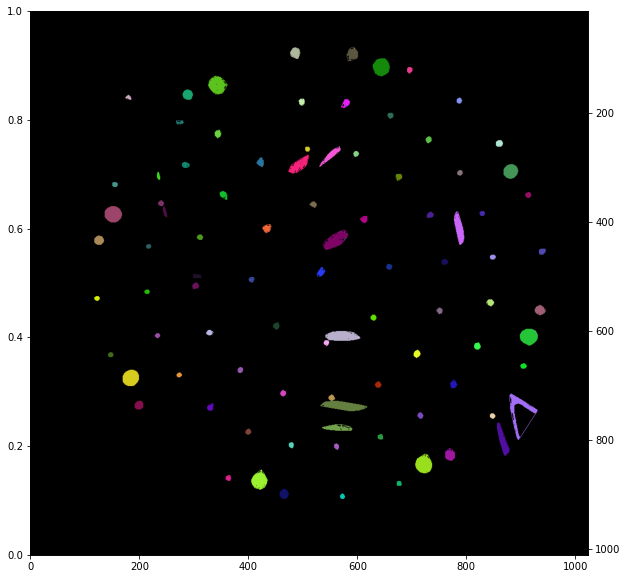

In [281]:
drawing = np.zeros((im1.shape[0], im1.shape[1], 3), dtype=np.uint8)
#drawing = im1.copy()
for i in range(len(regions)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(drawing, regions, i, color)
    cv.drawContours(drawing, hull_list, i, color)
plt.twinx()
#plt.imshow(im1,'gray')
plt.imshow(drawing)
plt.show()